In [14]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import  ARIMA
from pmdarima import auto_arima

from sklearn.metrics import mean_absolute_error

In [2]:
df = pd.read_csv('support/time_series.csv', index_col='date', parse_dates=['date']).squeeze()

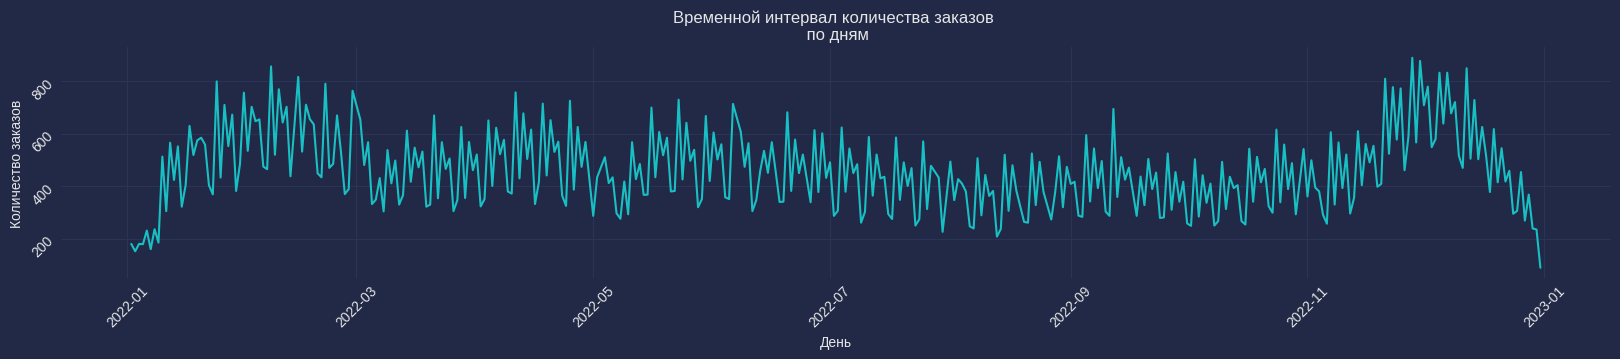

In [3]:
# Строим графики зависимости количества заказов от дня/месяца
fig = plt.figure(figsize=(20, 3))

days = sns.lineplot(x=df.index, y=df.values)

days.xaxis.set_tick_params(rotation=45)
days.yaxis.set_tick_params(rotation=45)
days.set(title='Временной интервал количества заказов \n по дням', xlabel='День', ylabel='Количество заказов');

**Чтобы суметь предсказать количетсво заказов на n-ых дней года, нам нужно определить во временном ряду тренд, сезонность, цикличность и шум.**

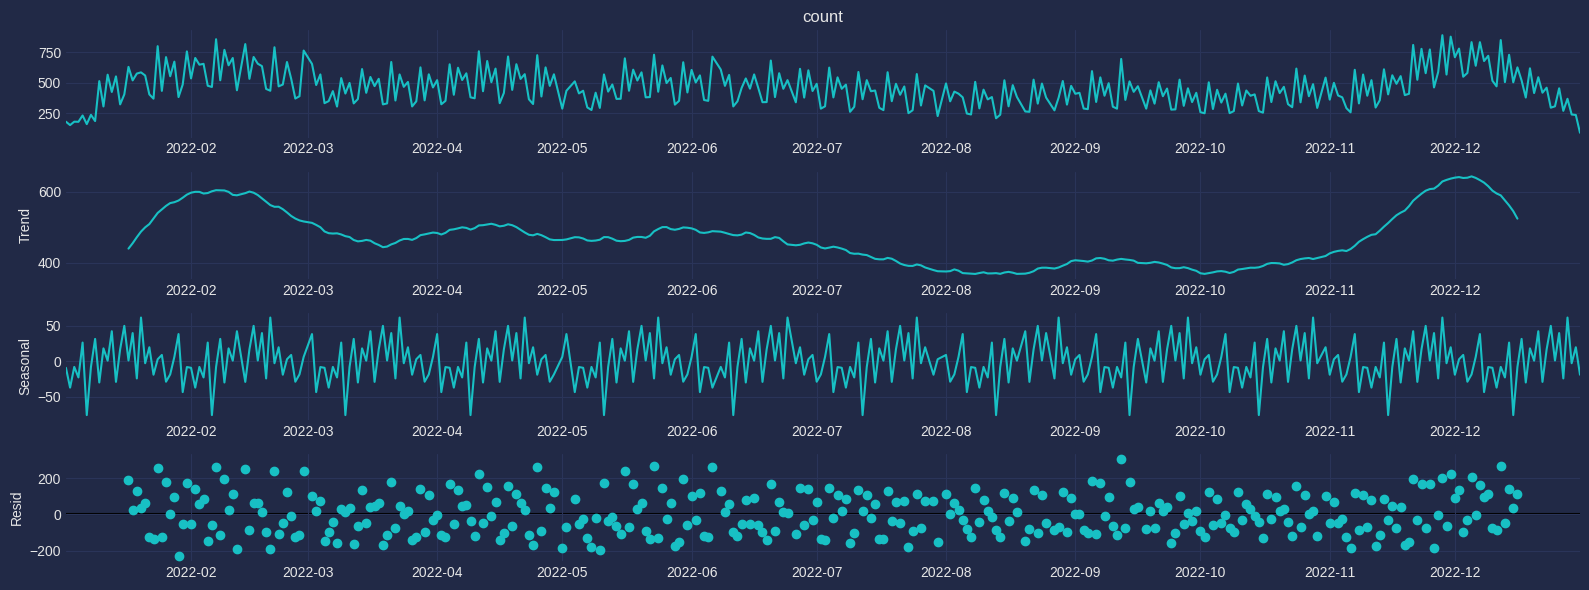

In [7]:
decomposition = seasonal_decompose(df, period=30)
fig = decomposition.plot()
plt.rcParams['figure.figsize'] = 10, 6
plt.show()

**При разбивке временного ряда видно, что как такого тренда нет, но пристствует цикличность**

**Проверим временной ряд на стационарность, так как такие ряды предсказать намного легче, чем не стационарные**

In [8]:
test = adfuller(df)
print('ADF Statistic: %f' % test[0])
print('p-value: %f' % test[1])
print('Critical Values:')
for key, value in test[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.931398
p-value: 0.041817
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571


**Значение статистики выше критического значения 1%-ого уровня значимости, но меньше 5%-ого уровня, не будем рисковать и принимем гипотезу Н0 (ряд не стационарный)**

**Приводим наш временной ряд к стационарности**

In [9]:
df_diff = df.diff(periods=1).dropna()

In [10]:
test_2 = adfuller(df_diff)
print('ADF Statistic: %f' % test_2[0])
print('p-value: %f' % test_2[1])
print('Critical Values:')
for key, value in test_2[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.105201
p-value: 0.000950
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571


**Ряд стационарен. Значение дифференцирования равное одному, будет достаточно**

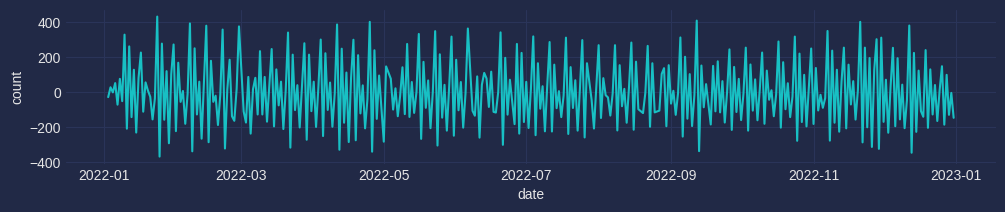

In [11]:
fig = plt.figure(figsize=(12, 2))
sns.lineplot(df_diff);

**Для будущих построений лучшей модели, мы должны опредлить несколько парметров(p,d,q)**

**Сделаем это с помощью автокорреляции и частичной автокорреляции**

/home/ya/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


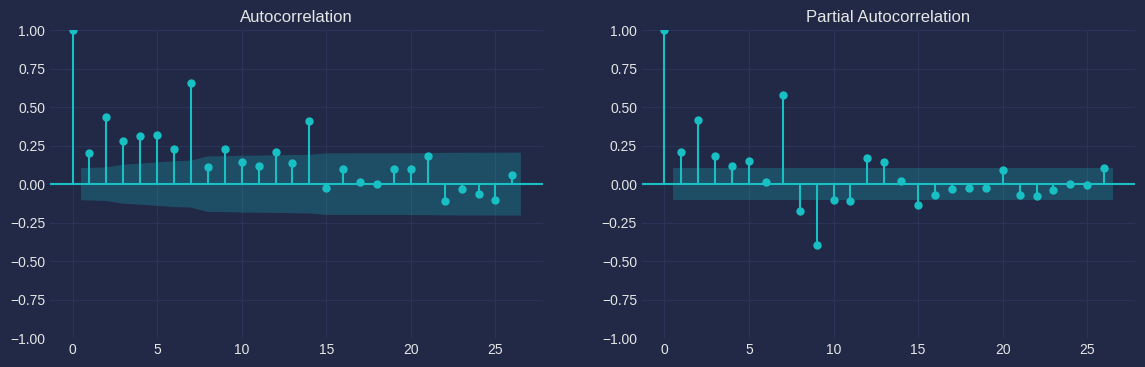

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(df, ax=axes[0])
plot_pacf(df, ax=axes[1]);

**Так как макисмальное значение автокоррелограммы и частичной автокоррелограммы находится на 7-ом значении, то временной ряд содержит циклическую компоненту с периодом недели.**

**Но наш ряд не стационарен, поэтому нужно построить частичную автокоррелограмму для стационарного ряда и выбрать значение p для моделей ARIMA**

<Figure size 1000x400 with 0 Axes>

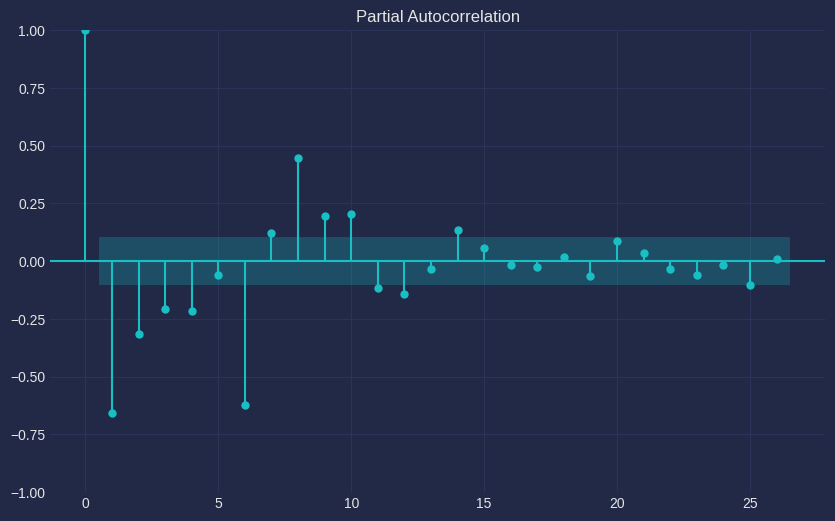

In [13]:
fig = plt.figure(figsize=(10, 4))
plot_pacf(df_diff);

**Значение p можно выбрать из числе: 8, 9, 10, 11, 12, 14**

In [15]:
# Разобьем нашу выборку на тренировочную и тестовую
train = df[:len(df) - 30]
test = df[len(df)-30:]

In [16]:
# с помощью просто модели AutoReg мы выберем значение p для более сложных моделей
def choice_p(value):
    erorrs = []

    for p in value:
        ar_model = AutoReg(train, lags=p).fit()
        pred = ar_model.predict(start=len(train), end=len(df)-1, dynamic=False)
        erorrs.append([p, mean_absolute_error(test, pred)])

    return erorrs

In [17]:
errors = choice_p([8, 9, 10, 11, 12, 14])

/home/ya/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ya/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/ya/.local/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/home/ya/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no assoc

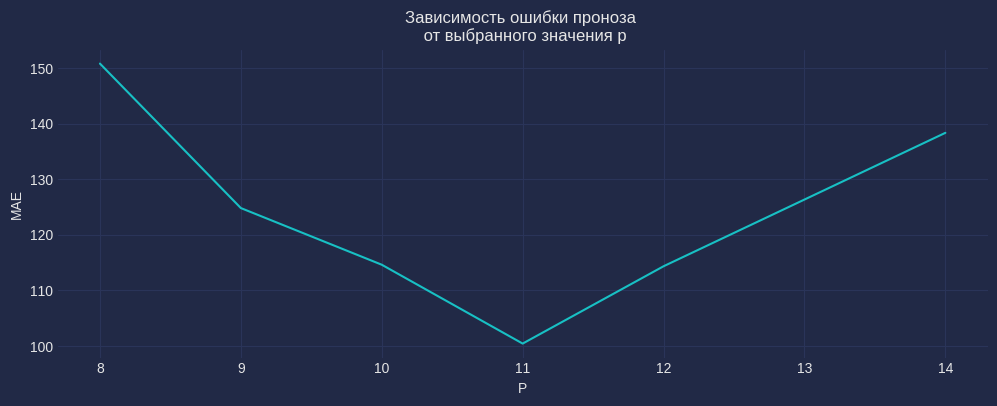

In [18]:
# визуализируем наши значения
fig = plt.figure(figsize=(12, 4))

ax = sns.lineplot(x=[p[0] for p in errors], y=[mae[1] for mae in errors])
ax.set(title='Зависимость ошибки проноза \n от выбранного значения p', xlabel='P', ylabel='MAE');

**При P равное 11 ошибка минимальна, но значение ошибки на моделе AutoReg еще велико**

**Также нужно определить значение (q) скользящей средней**

In [19]:
# функция принимает временный ряд и число, по которму нужно сгладить скользящую среднюю.
# И визуализирует результаты
def plotMovingAvarage(series, n):

    rolling_mean = series.rolling(window=n).mean()

    plt.figure(figsize=(12,3))
    plt.title(f"Moving average\n window size = {n}")
    
    sns.lineplot(x=rolling_mean.index, y=rolling_mean.values, color='#d8f51b', label='rolling')
    sns.lineplot(x=df[n:].index, y=df[n:].values, color='#2facf5', label='actual')

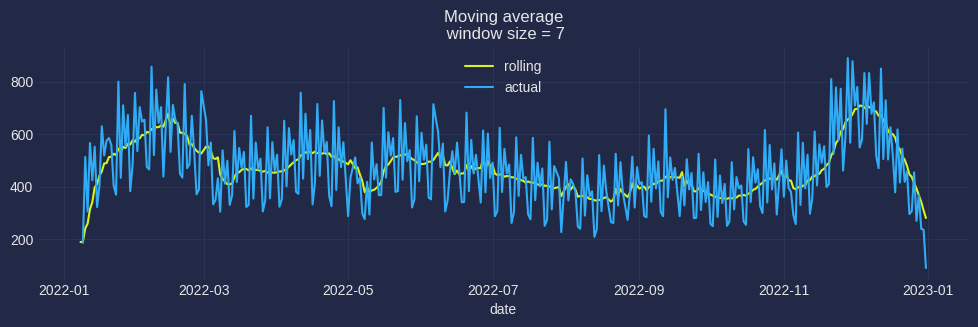

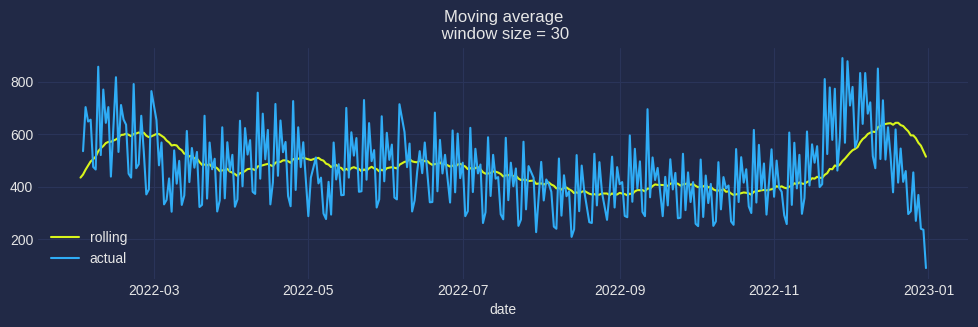

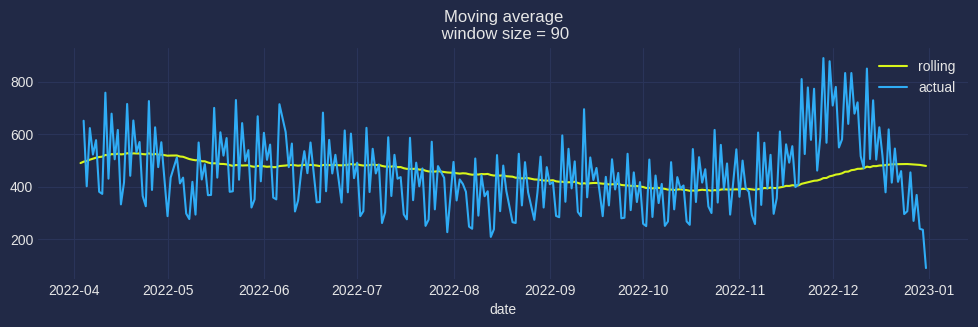

In [20]:
plotMovingAvarage(df, 7)
plotMovingAvarage(df, 30)
plotMovingAvarage(df, 90)

**Параметр q равным 7 больше отабражает зависимость нашего ряда**

**Построим AR-модели на выбранных параметрах**

In [21]:
def show_result(fit_model: object, model_name: str, n=30, exg=False):
    """Функция визуализирует результаты предсказания модели для тестового периода и n дней вперед

    Args:
        fit_model (_type_): модель, по которой нужно предсказать значения
        model_name (_type_): навзание модели
        n (int, optional): Количество дней на которые нужно предсказать значения
        exg (bool, optional): Параметр пр помощи которого определяет использовать ли дополнительные данные для предсказания
    """
    
    print(f'AIC on {model_name}: {fit_model.aic}')

    pred_df = pd.DataFrame(index=df.index)
    if exg:
        pred = fit_model.predict(start=len(train)+1, end=len(train)+30, exog=holidays[-1])
    else:
        pred = fit_model.predict(start=len(train)+1, end=len(train)+30)
    df_pred = pd.DataFrame(index=test.index, data=pred.values, columns=[model_name])

    fig, axes = plt.subplots(2, 2,  figsize=(20, 8))

    line = sns.lineplot(x=df_pred.index, y=df_pred[model_name], label='Predict', color='#ed0c35', ax=axes[0][0])
    line = sns.lineplot(x=df.index, y=df.values, label='Basic', color='#0c80ed', ax=axes[0][0])
    line.set(title=f'Предсказание модели {model_name} \n на декабрь данного года')

    zoom_p = sns.lineplot(x=df_pred.index, y=df_pred[model_name], label='Predict', color='#ed0c35', ax=axes[1][0])
    zoom_b = sns.lineplot(x=df[-30:].index, y=df[-30:].values, label='Basic', color='#0c80ed', ax=axes[1][0])
    zoom_b.set(title=f'Предсказание модели {model_name} \n на декабрь данного года \n в увеличенном масштабе')
    zoom_b.xaxis.set_tick_params(rotation=45);

    #---------------------------------------------------------------------------
    dates = pd.to_datetime([str(date).replace('2022', '2023') for date in list(df[:n].index)])
    pred_ser = pd.Series(index=dates, data=[0]*len(dates))

    pred_ar = fit_model.predict(start=df.index[0], end=df.index[n-1])
    pred_ser = pd.Series(data=pred_ar.values, index=pred_ser.index)

    #------------------------------------------------------
    line_future = sns.lineplot(x=df.index, y=df.values, label='Basic', color='#0c80ed', ax=axes[0][1])
    line_future = sns.lineplot(x=pred_ser.index, y=pred_ser.values, label='Predict', color='#ed0c35', ax=axes[0][1])
    line_future.set(title=f'Предсказание модели {model_name} \n на {n} дней следующего года')

    zoom_p_fut = sns.lineplot(x=df[:n].index, y=pred_ser.values, label='Predict', color='#ed0c35', ax=axes[1][1])
    zoom_b_fut = sns.lineplot(x=df[:n].index, y=df[:n].values, label='Basic', color='#0c80ed', ax=axes[1][1])
    zoom_b_fut.xaxis.set_tick_params(rotation=45)
    zoom_b_fut.set(title=f'Предсказание модели {model_name} \n на {n} дней следующего года \n в увеличенном масштабе');

    plt.tight_layout()

/home/ya/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ya/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ya/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ya/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregre

AIC on arima: 3812.5083516464883


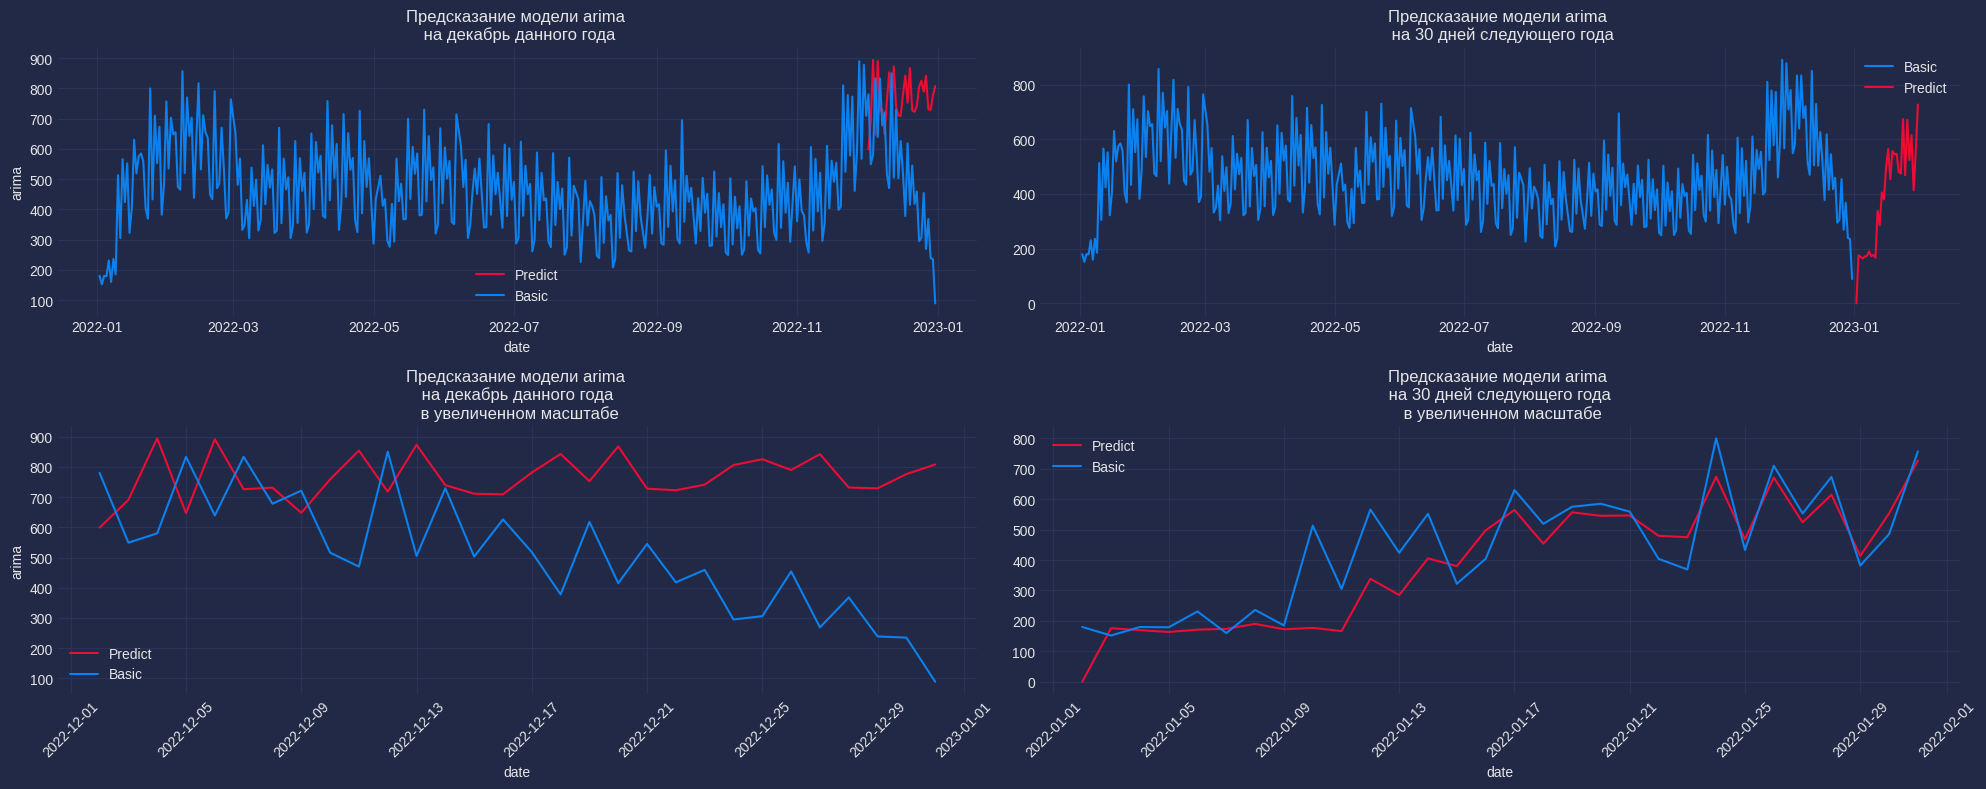

In [22]:
# Попробуем просутю модель Arima на наших собранных параметрах
arima = ARIMA(train, order=(11,1,7))
arima_fit = arima.fit()
show_result(arima_fit, 'arima', 30)

**Как видно модель плохо уловила зависимость на тестовой выборке, но вполне неплохо сделала прогноз на 30 дней вперед**

**С помощью auto_arima попробуем подобрать параметры автоперебором**

In [23]:
smodel = auto_arima(
    df, start_p=1, start_q=1, test='adf',
    max_p=15, max_q=15, m=7,
    start_P=0, start_Q=0, seasonal=True,
    d=None, D=1, trace=True, error_action='ignore',
    suppress_warnings=True, stepwise=True
    )
smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,0)[7] intercept   : AIC=4214.214, Time=0.20 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=4257.292, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=4261.102, Time=0.13 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=4261.158, Time=0.25 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=4255.382, Time=0.01 sec
 ARIMA(1,0,1)(1,1,0)[7] intercept   : AIC=4201.352, Time=1.01 sec
 ARIMA(1,0,1)(2,1,0)[7] intercept   : AIC=4203.352, Time=1.46 sec
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=4202.252, Time=0.95 sec
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=4200.823, Time=0.61 sec
 ARIMA(1,0,1)(0,1,2)[7] intercept   : AIC=4202.279, Time=0.98 sec
 ARIMA(1,0,1)(1,1,2)[7] intercept   : AIC=inf, Time=1.94 sec
 ARIMA(1,0,0)(0,1,1)[7] intercept   : AIC=4261.133, Time=0.08 sec
 ARIMA(2,0,1)(0,1,1)[7] intercept   : AIC=4135.856, Time=0.45 sec
 ARIMA(2,0,1)(0,1,0)[7] intercept   : AIC=4140.046, Time=0.17 sec
 ARIMA(2,0,1)(1,1,1)[7] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  352
Model:             SARIMAX(4, 0, 0)x(0, 1, [1], 7)   Log Likelihood               -2055.902
Date:                             Fri, 13 Jan 2023   AIC                           4123.804
Time:                                     19:28:41   BIC                           4146.866
Sample:                                          0   HQIC                          4132.989
                                             - 352                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1464      0.042     -3.470      0.001      -0.229      -0.064
ar.L2          0.3779      0.044      8.685      0.000       0.293       0.463
ar.L3          0.2830      0.045      6.332      0.000       0.195       0.371
ar.L4          0.2839      0.047      6.104      0.000       0.193       0.375
ma.S.L7       -0.1363      0.051     -2.682      0.007      -0.236      -0.037
sigma2      8755.4331    477.544     18.334      0.000    7819.463    9691.403
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                80.92
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                             0.24
Prob(H) (two-sided):                  0.02   Kurtosis:                         5.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
# запишем поборанные параметры и попробуем предсказать количесвто заказов уже на моделе SARIMA
order = (4,0,0)
seasonal_order = (0,1,1,7)

sarima = SARIMAX(df, order=order, seasonal_order=seasonal_order)
sarima_fit = sarima.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.84652D+00    |proj g|=  5.91900D-02

At iterate    5    f=  5.84074D+00    |proj g|=  1.95732D-03

At iterate   10    f=  5.84073D+00    |proj g|=  2.32249D-04

At iterate   15    f=  5.84068D+00    |proj g|=  3.54672D-03

At iterate   20    f=  5.84063D+00    |proj g|=  9.35563D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     25      1     0     0   2.447D-05   5.841D+00
  F =   5.8406313753371828     

CONVERG

/home/ya/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ya/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


AIC on sarima: 4123.804488237377


/home/ya/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


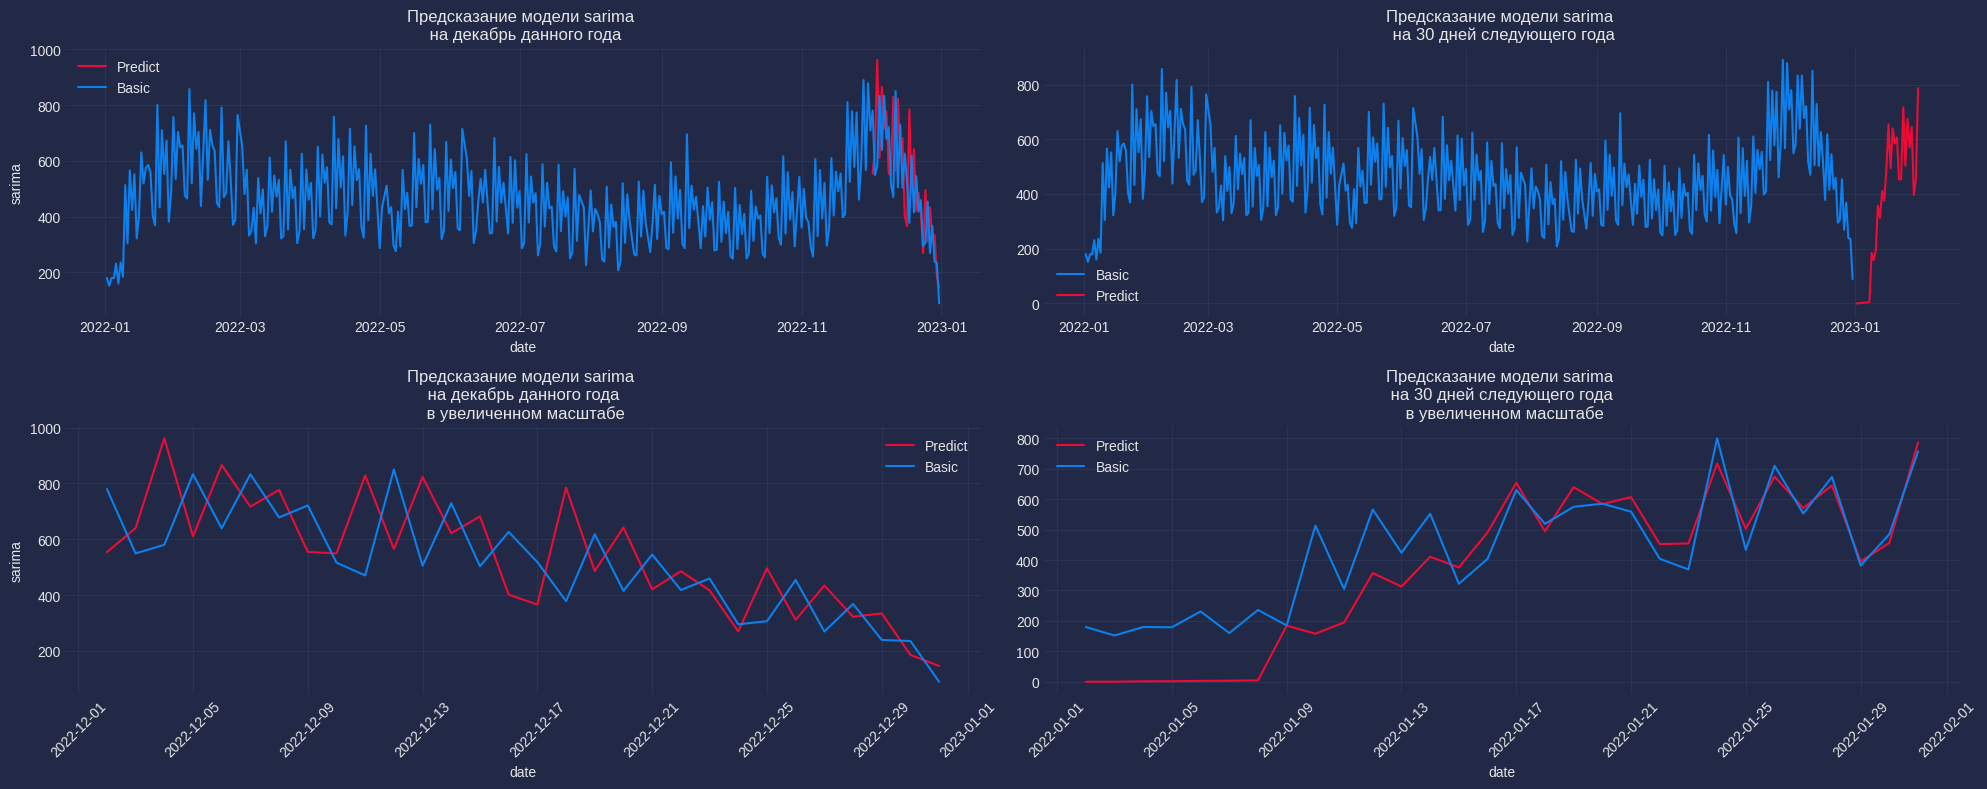

In [25]:
show_result(sarima_fit, 'sarima')

**Модель неплохо предсказала падающий тренд на тестовой выборке, но на первые будущие две недели сделала плохое предсказание.**

**Попробуем дополнить нашу модель праздниками и используем для нашего предсказания модель SARIMAX.**

In [26]:
# создадим обьект Series с обозначением праздников или их отсутствием на каждую дату
# единицей будет обозначен праздник, одной второй предпраздничные дни, а ноль-отсутствия праздника
holidays = pd.Series(data=[0]*len(df), index=df.index)
# новогодние праздники
holidays.at['2022-01-02'] = 1
holidays.at['2022-01-03'] = 1
holidays.at['2022-01-04'] = 1
holidays.at['2022-01-05'] = 1
holidays.at['2022-01-06'] = 1
holidays.at['2022-01-07'] = 1
holidays.at['2022-01-08'] = 1
# 23 февраля
holidays.at['2022-02-22'] = 0.5
holidays.at['2022-02-23'] = 1
# 8марта
holidays.at['2022-03-07'] = 0.5
holidays.at['2022-03-08'] = 1

# майские праздники
holidays.at['2022-05-01'] = 1
holidays.at['2022-05-02'] = 1
holidays.at['2022-05-04'] = 1
holidays.at['2022-05-05'] = 1
holidays.at['2022-05-06'] = 1
holidays.at['2022-05-07'] = 1
holidays.at['2022-05-08'] = 1
holidays.at['2022-05-09'] = 1
holidays.at['2022-05-10'] = 0.5
# день России
holidays.at['2022-06-11'] = 0.5
holidays.at['2022-06-12'] = 1
# первое сентября
holidays.at['2022-08-31'] = 0.5
holidays.at['2022-09-01'] = 1
# Новый год
holidays.at['2022-12-29'] = 0.5
holidays.at['2022-12-30'] = 0.5
holidays.at['2022-12-31'] = 1

In [27]:
sarimax = SARIMAX(df, order=order, seasonal_order=seasonal_order, exog=holidays)
sarimax_fit = sarimax.fit()

/home/ya/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ya/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.79235D+00    |proj g|=  4.90655D-02

At iterate    5    f=  5.79062D+00    |proj g|=  5.15381D-04

At iterate   10    f=  5.79060D+00    |proj g|=  2.47849D-03

At iterate   15    f=  5.78862D+00    |proj g|=  2.59366D-02

At iterate   20    f=  5.78525D+00    |proj g|=  3.87246D-03

At iterate   25    f=  5.78521D+00    |proj g|=  3.20731D-03

At iterate   30    f=  5.78445D+00    |proj g|=  2.21451D-02

At iterate   35    f=  5.78351D+00    |proj g|=  5.34501D-04

At iterate   40    f=  5.78351D+00    |proj g|=  2.51884D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

AIC on sarimax: 4085.5898173535816


/home/ya/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


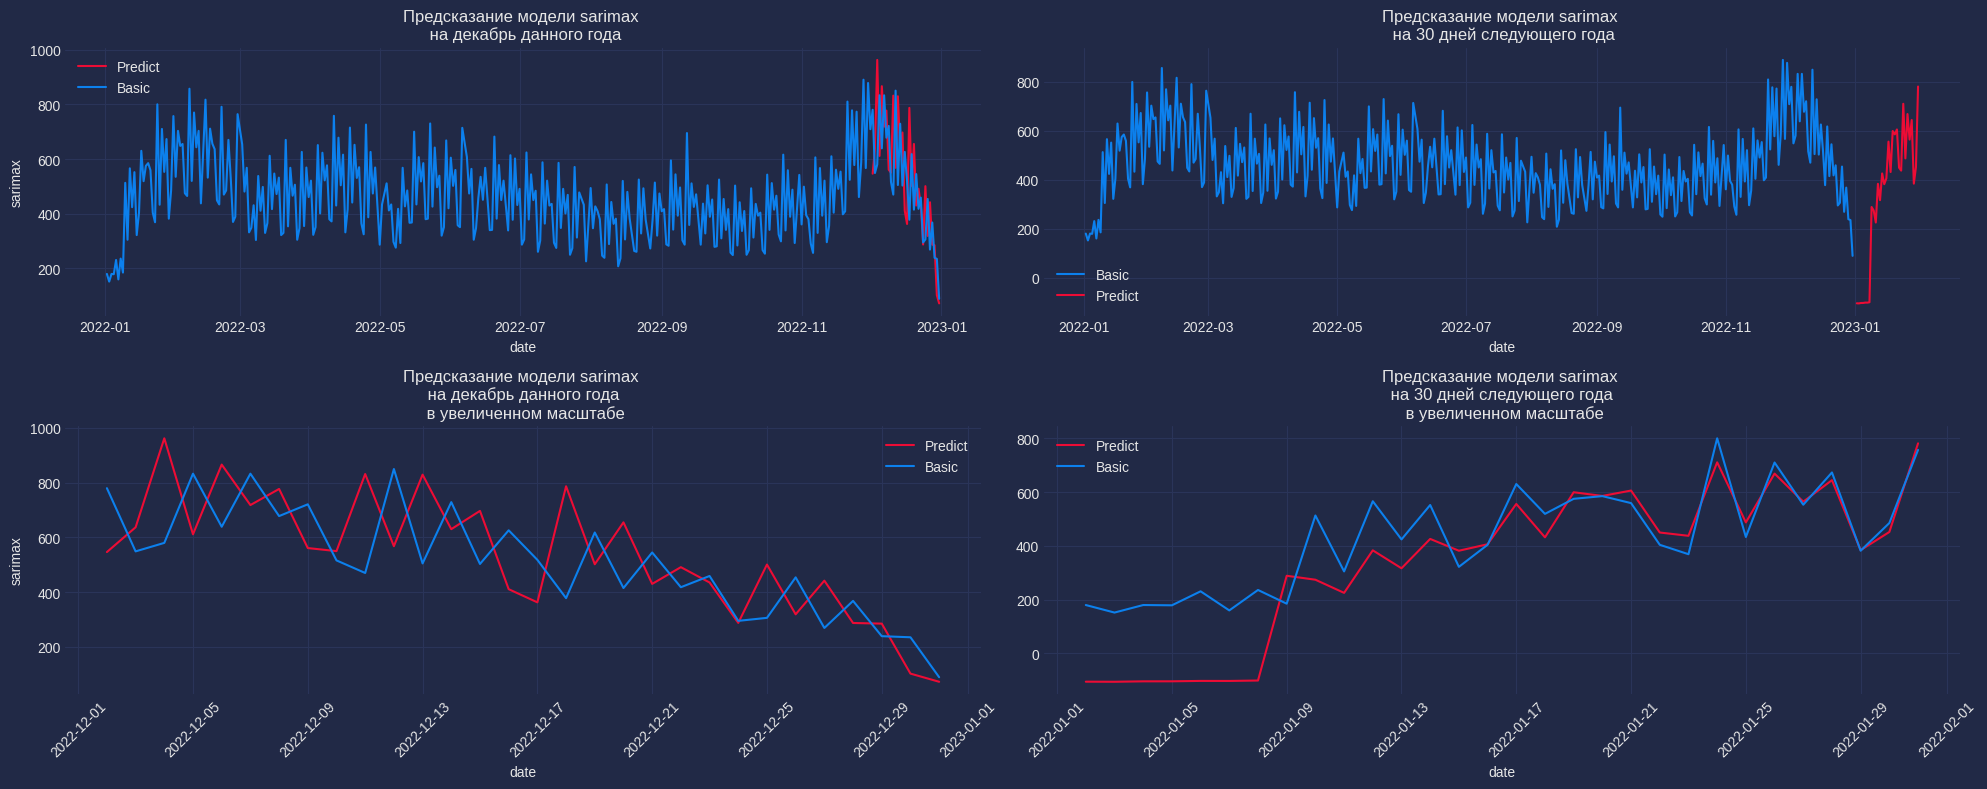

In [28]:
show_result(sarimax_fit, 'sarimax', exg=True)

**Такой же результат показала модель SARIMAX c дополнительным признаком праздников. При этом простая модель ARIMA с нашими, подобранными в ручную параметрами, показала метрику AIC ниже чем все модели.**

**Логично будет использовать эти же параметры, но уже на моделе SARIMAX**

In [29]:
sarimax_mode = SARIMAX(df, exog=holidays, order=(11,1,7), seasonal_order=(0,1,1,12))
sarimax_mode_fit = sarimax_mode.fit()

/home/ya/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ya/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ya/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ya/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.22051D+00    |proj g|=  2.36361D+00

At iterate    5    f=  5.78662D+00    |proj g|=  1.00047D-01

At iterate   10    f=  5.73404D+00    |proj g|=  9.96118D-02

At iterate   15    f=  5.71550D+00    |proj g|=  6.30484D-02

At iterate   20    f=  5.70919D+00    |proj g|=  9.19432D-03

At iterate   25    f=  5.70789D+00    |proj g|=  8.18176D-03

At iterate   30    f=  5.70666D+00    |proj g|=  1.76177D-02

At iterate   35    f=  5.70554D+00    |proj g|=  1.46658D-02

At iterate   40    f=  5.70479D+00    |proj g|=  1.99074D-02

At iterate   45    f=  5.70395D+00    |proj g|=  2.96405D-02


/home/ya/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  5.70320D+00    |proj g|=  4.01024D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     57      1     0     0   4.010D-02   5.703D+00
  F =   5.7032026365519108     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


AIC on sarimax_mode: 4057.0546561325455


/home/ya/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


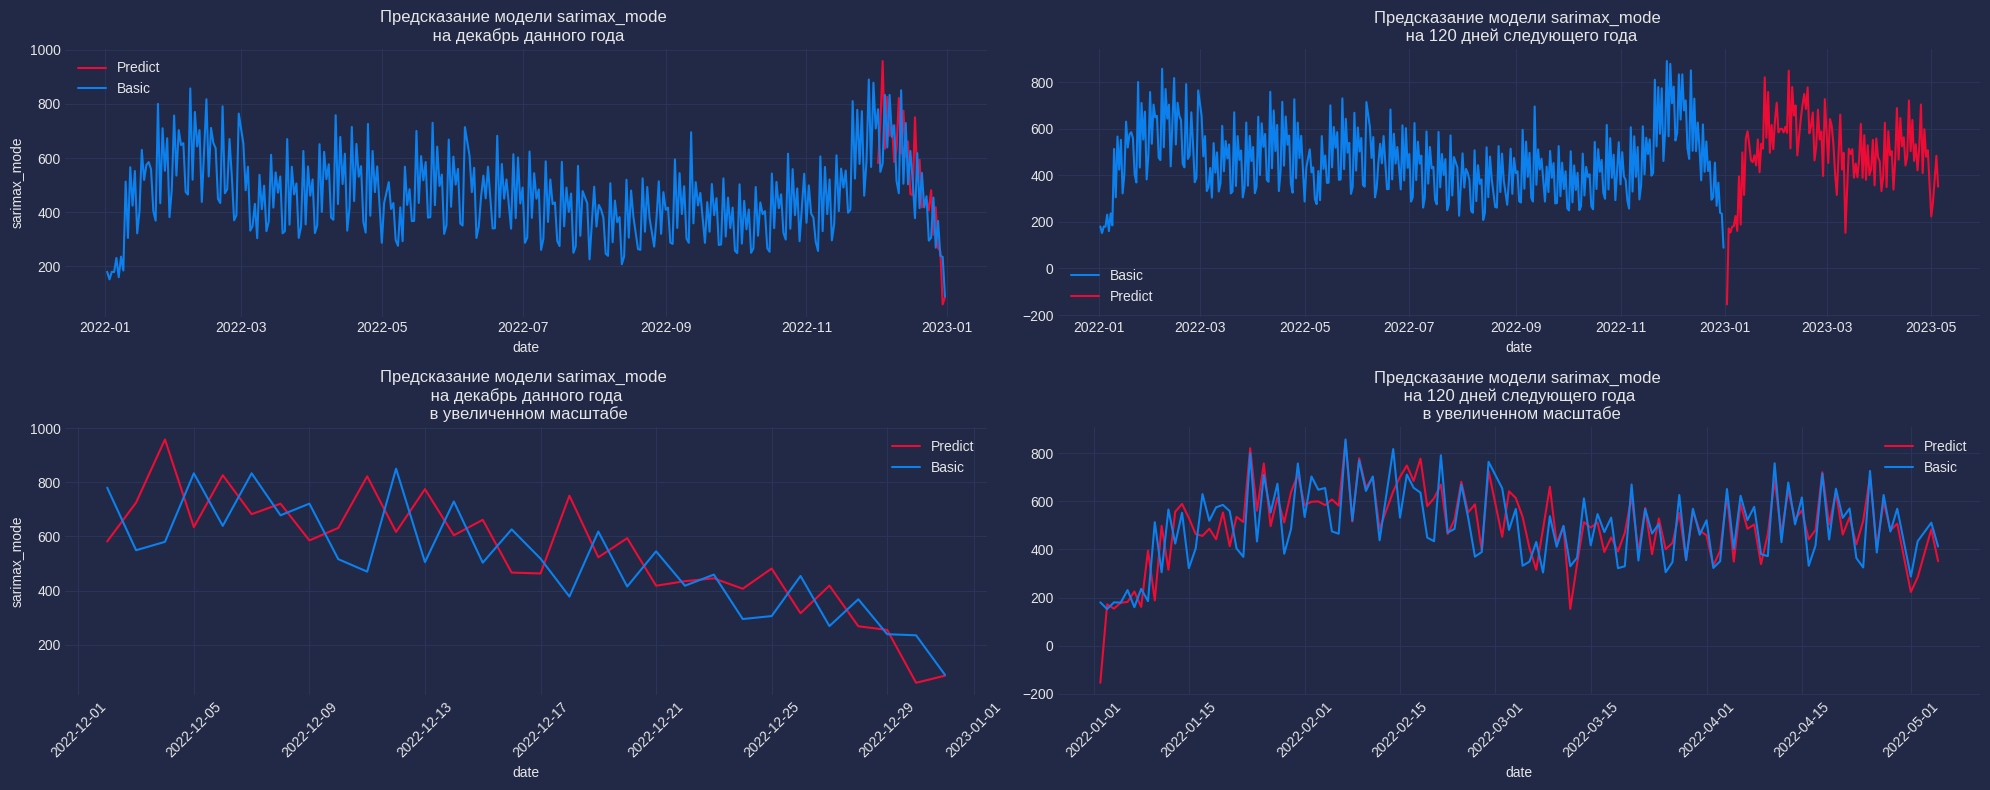

In [30]:
# предскажем значения на 120 дней вперед
show_result(sarimax_mode_fit, 'sarimax_mode', n=120, exg=True)

**Как видно по графикам, модель уловила и падающий тренд на тестовой выборке и неплохо предсказала значения на 4 месяца вперед**

**Визуализируем наши результаты**

In [31]:
def get_mae(fit_model, exg=False):
    pred_df = pd.DataFrame(index=df.index)

    if exg:
        pred = fit_model.predict(start=len(train)+1, end=len(train)+30, exog=holidays[-1])
    else:
        pred = fit_model.predict(start=len(train)+1, end=len(train)+30)
    
    return mean_absolute_error(test.values, pred.values).round(2)


In [32]:
maes, aics = [], []
for model in [arima_fit, sarima_fit, sarimax_fit, sarimax_mode_fit]:
    try:
        mae = get_mae(model)
        aic_score = model.aic
    except Exception:
        mae = get_mae(model, exg=True)
        aic_score = model.aic
    maes.append(mae)
    aics.append(aic_score)

result = pd.DataFrame({'MODEL':['arima', 'sarima', 'sarimax', 'sarimax_mode'],'MAE': maes, 'AIC':aics})
result

/home/ya/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/ya/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/ya/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/ya/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/ya/.local/lib/python3.10/site-packages

,MODEL,MAE,AIC
0,arima,295.68,3812.508352
1,sarima,165.29,4123.804488
2,sarimax,165.19,4085.589817
3,sarimax_mode,153.56,4057.054656


**По таблице видно, что модель sarimax_mode меньше всего допустила ошибок при прогнозе на 30 дней.**

**Несмотря на то что у обычной модели arima меньше показатель AIC, я больше склонен доверять sarimax_mode, так как на тестовой выборке она показала себя хорошо, уловив падающий тренд, так и новый прогноз дал меньше всего ошибок**